In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch import tensor, Tensor
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import Conv2d, InstanceNorm2d, ConvTranspose2d
from torch import optim 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset 
from torchvision import transforms
import torchvision

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# this won't work if the drive is shared with you
# solution: right click on the shared CS7643 project folder and select 'add shortcut to my drive'
%cd gdrive/My\ Drive/CS7643_Final_Project

In [5]:
class bVAE(nn.Module):
  def __init__(self, latent_dim):
    super(bVAE, self).__init__()
    self.latent_dim = latent_dim
    # Encoder
    self.c1 = nn.Conv2d(1, 32, kernel_size = 4, stride = 2, padding = 1)
    self.b1 = nn.BatchNorm2d(32)
    self.c2 = nn.Conv2d(32, 64, kernel_size = 4, stride = 2, padding = 1)
    self.b2 = nn.BatchNorm2d(64)
    self.c3 = nn.Conv2d(64, 64, kernel_size = 4, stride = 1, padding = 1)
    self.b3 = nn.BatchNorm2d(64)

    self.c4 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
    self.b4 = nn.BatchNorm2d(64)

    self.fc1 = nn.Linear(64 * 6 * 6, latent_dim)
    self.fc2 = nn.Linear(64 * 6 * 6, latent_dim)

    # Decoder
    self.fc3 = nn.Linear(latent_dim, 64 * 6 * 6)

    self.d0 = nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
    self.db0 = nn.BatchNorm2d(64)

    self.d1 = nn.ConvTranspose2d(64, 64, kernel_size = 4, stride = 1, padding = 1)
    self.db1 = nn.BatchNorm2d(64)
    self.d2 = nn.ConvTranspose2d(64, 32, kernel_size = 4, stride = 2, padding = 1)
    self.db2 = nn.BatchNorm2d(32)
    self.d3 = nn.ConvTranspose2d(32, 1, kernel_size = 4, stride = 2, padding = 1)
    self.db3 = nn.BatchNorm2d(1)
    self.sigmoid = nn.Sigmoid()
  
  def encode(self, x):
    out = F.relu(self.b1(self.c1(x)))
    out = F.relu(self.b2(self.c2(out)))
    out = F.relu(self.b3(self.c3(out)))
    out = F.relu(self.b4(self.c4(out)))
    # Resize from (batch_size, num_classes, w, h) to (batch_size,num_classes*w*h)
    out = out.view(out.shape[0], -1)
    mu, logvar = F.relu(self.fc1(out)), F.relu(self.fc2(out))
    return mu, logvar
  
  def decode(self, z):
    out = F.relu(self.fc3(z))
    out = out.view(-1, 64, 6, 6)
    out = F.relu(self.db0(self.d0(out)))
    out = F.relu(self.db1(self.d1(out)))
    out = F.relu(self.db2(self.d2(out)))
    return self.sigmoid(self.db3(self.d3(out)))
  
  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

In [7]:
pretrained_vae = bVAE(30).eval().to(device)
pretrained_vae.load_state_dict(torch.load('bVAE_Quickdraw.pt'))

for param in pretrained_vae.parameters():
  param.requires_grad_(False)

In [106]:
class Decoder_classifier(nn.Module):
  def __init__(self):
    super(Decoder_classifier, self).__init__()
    self.fc1 = nn.Linear(30, 50)
    self.bn1 = nn.BatchNorm1d(50)
    self.fc2 = nn.Linear(50, 40)
    self.bn2 = nn.BatchNorm1d(40)
    self.fc3 = nn.Linear(40, 30)
    self.bn3 = nn.BatchNorm1d(30)
    self.fc4 = nn.Linear(30, 20)
    self.bn4 = nn.BatchNorm1d(20)
    self.fc5 = nn.Linear(20, 10)

    self.dropout = nn.Dropout(0.25)
  
  def forward(self, x):
    mu, logvar = pretrained_vae.encode(x)
    z = pretrained_vae.reparameterize(mu,logvar)
    
    out = F.selu(self.bn1(self.fc1(z)))
    out = F.selu(self.bn2(self.fc2(out)))
    out = F.selu(self.bn3(self.fc3(out)))
    out = F.selu(self.bn4(self.fc4(out)))
    out = self.fc5(out)
    return out

In [49]:
def evaluate_model(model, dataloader, dtype = 'Test', criterion = nn.CrossEntropyLoss()):
    """
    Calculates the average loss and accuracy of the model on a dataset
    """
    model.eval() # Notify all layers we're in eval mode instead of training mode
    loss, total, correct = 0, 0, 0
    n = 0
    with torch.no_grad():
      for xs, ys in dataloader:
          output = model(xs.to(device))
          loss += criterion(output, ys.to(device)).item()
          _, predictions = torch.max(output.data, 1)
          total += ys.size(0)
          correct += (predictions == ys.to(device)).sum().item()
          n += 1
    
    if dtype != 'Train':
      print(f'\n{dtype} loss: {loss / n: .2f} | {dtype} accuracy: {correct / total : .2f}')
    return loss / n, 100 * correct / total

In [36]:
def load_data(batch_size = 128):
    """
    Returns a list of PyTorch DataLoaders in order of train, validation, and test loaders
    """
    dirnames = ['Train/', 'Validation/', 'Test/']
    loaders = []

    for dirname in dirnames:
        dataname = os.listdir(dirname)[0]
        xs = np.load(dirname + dataname)['data'].reshape(-1, 1, 28, 28)
        ys = np.load(dirname + dataname)['target']

        xs = Tensor(xs).to(device)
        ys = tensor(ys, dtype = torch.long).to(device)

        xs /= 255
        mu = torch.mean(xs, dim = (0, 2, 3))
        std = torch.std(xs, dim = (0, 2, 3))

        transform = transforms.Compose([transforms.Normalize((mu,), (std,))])
        xs = transform(xs)

        print(f'Loading {dataname} into Pytorch Dataloader ... Xs shape: {xs.shape}, Ys shape: {ys.shape}')
        loaders.append(DataLoader(TensorDataset(xs, ys), batch_size = batch_size, shuffle=True))
    
    return loaders

In [33]:
classes = ['tree.npy', 't-shirt.npy', 'ice cream.npy', 'fish.npy', 'face.npy', 'car.npy', 'bowtie.npy', 'apple.npy', 'flamingo.npy', 'sheep.npy']

In [34]:
batch_size = 128

In [107]:
train_data_loader, valid_data_loader, test_data_loader = load_data(batch_size)

Loading Train.npz into Pytorch Dataloader ... Xs shape: torch.Size([84000, 1, 28, 28]), Ys shape: torch.Size([84000])
Loading Validation.npz into Pytorch Dataloader ... Xs shape: torch.Size([36000, 1, 28, 28]), Ys shape: torch.Size([36000])
Loading Test.npz into Pytorch Dataloader ... Xs shape: torch.Size([30000, 1, 28, 28]), Ys shape: torch.Size([30000])


In [108]:
classifier = Decoder_classifier().to(device)
optimizer = optim.Adam(params = classifier.parameters())
criterion = nn.CrossEntropyLoss()

In [110]:
losses, acc = [], []
valid_losses, valid_acc = [], []
test_losses, test_acc = [], []
epochs = 40
best_loss = float('inf')

In [111]:
for epoch in range(1, epochs + 1):
  total = 0
  n = 0
  for x, y in train_data_loader:

    optimizer.zero_grad()
    
    out = classifier(x.to(device))
    loss = criterion(out, y.to(device))
    loss.backward()
    optimizer.step()

    total += loss.item()
    n += 1
  
  losses.append(total / n)
  
  _, train_accuracy = evaluate_model(classifier, train_data_loader, 'Train')
  valid_loss, valid_accuracy = evaluate_model(classifier, valid_data_loader, 'Validation')
  test_loss, test_accuracy = evaluate_model(classifier, test_data_loader, 'Test')
  
  # save the model that performs best on the test set
  if test_loss < best_loss:
    best_loss = test_loss
    torch.save(classifier.state_dict(), 'bvae_classifier_quickdraw.pt')
  
  # put model back in train mode after putting it in eval mode
  classifier.train()
  
  test_losses.append(test_loss)
  acc.append(train_accuracy)
  test_acc.append(test_accuracy)
  valid_losses.append(valid_loss)
  valid_acc.append(valid_accuracy)
  
  print('Epoch: {}, Avg Loss: {:.4f}, Avg Accuracy: {:.2f}'.format(epoch, total / n, train_accuracy))


Validation loss:  0.42 | Validation accuracy:  0.88

Test loss:  0.40 | Test accuracy:  0.88
Epoch: 1, Avg Loss: 0.6150, Avg Accuracy: 88.62

Validation loss:  0.38 | Validation accuracy:  0.89

Test loss:  0.37 | Test accuracy:  0.89
Epoch: 2, Avg Loss: 0.3958, Avg Accuracy: 89.46

Validation loss:  0.36 | Validation accuracy:  0.89

Test loss:  0.35 | Test accuracy:  0.90
Epoch: 3, Avg Loss: 0.3645, Avg Accuracy: 89.97

Validation loss:  0.35 | Validation accuracy:  0.89

Test loss:  0.34 | Test accuracy:  0.90
Epoch: 4, Avg Loss: 0.3491, Avg Accuracy: 90.20

Validation loss:  0.34 | Validation accuracy:  0.90

Test loss:  0.33 | Test accuracy:  0.90
Epoch: 5, Avg Loss: 0.3388, Avg Accuracy: 90.68

Validation loss:  0.34 | Validation accuracy:  0.90

Test loss:  0.33 | Test accuracy:  0.90
Epoch: 6, Avg Loss: 0.3292, Avg Accuracy: 90.75

Validation loss:  0.33 | Validation accuracy:  0.90

Test loss:  0.32 | Test accuracy:  0.90
Epoch: 7, Avg Loss: 0.3249, Avg Accuracy: 91.10

Valid

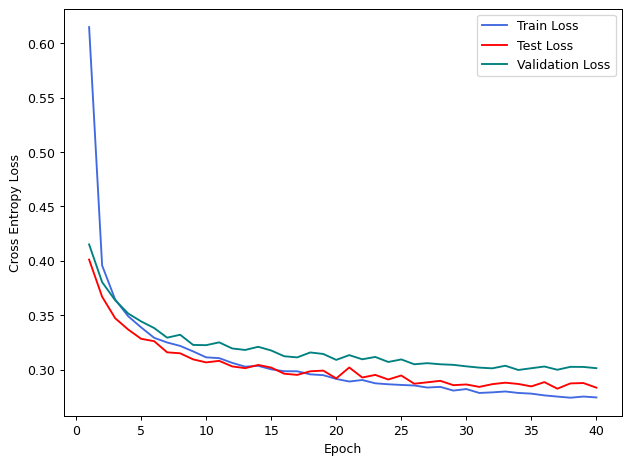

In [112]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 90

plt.plot(list(range(1, epochs + 1)), losses, color='royalblue')
plt.plot(list(range(1, epochs + 1)), test_losses, color = 'red')
plt.plot(list(range(1, epochs + 1)), valid_losses, color='teal')

plt.legend(['Train Loss', 'Test Loss', 'Validation Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()

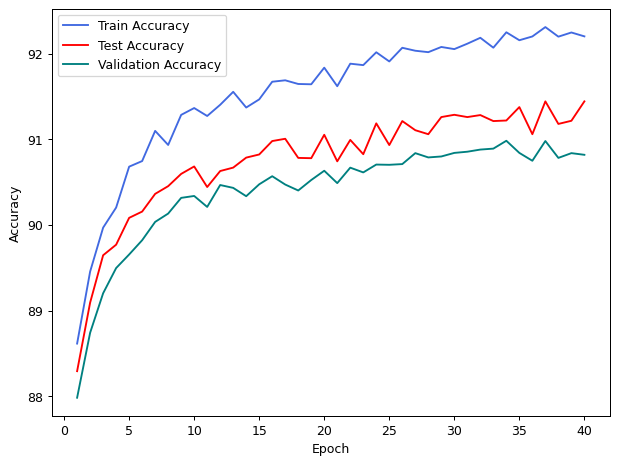

In [113]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 90 

plt.plot(list(range(1, epochs + 1)), acc, color='royalblue')
plt.plot(list(range(1, epochs + 1)), test_acc, color = 'red')
plt.plot(list(range(1, epochs + 1)), valid_acc, color='teal')

plt.legend(['Train Accuracy', 'Test Accuracy', 'Validation Accuracy'], loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [114]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_mnist(model, dataloader):
  preds, labels = torch.Tensor([]).to(device), torch.Tensor([]).to(device)
  
  with torch.no_grad():
    for x_batch, y_batch in dataloader:
      out = model(x_batch.to(device))
      preds = torch.cat((preds, out), dim = 0)
      labels = torch.cat((labels, y_batch.to(device)), dim = 0)
  
  preds = torch.argmax(preds, dim = 1)

  count_matrix = torch.zeros((10, 10)).to(device)
  
  for pred, label in zip(preds, labels):
    count_matrix[int(pred)][int(label)] += 1
  
  count_matrix = count_matrix / count_matrix.sum(axis = 1)

  plt.imshow(count_matrix.cpu(), interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion matrix')
  marks = list(range(10))
  class_names = ['tree', 't-shirt', 'ice cream', 'fish', 'face', 'car', 'bowtie', 'apple', 'flamingo', 'sheep']
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.xticks(marks, class_names)
  plt.yticks(marks, class_names)

  threshold = count_matrix.max() / 2
  # label each grid with its count
  for i in range(10):
    for j in range(10):
      plt.text(j, i, format(count_matrix[i][j], '.2f'), ha="center", va="center",
                    color="white" if count_matrix[i][j] > threshold else "black")
  
  plt.colorbar()
  plt.show()

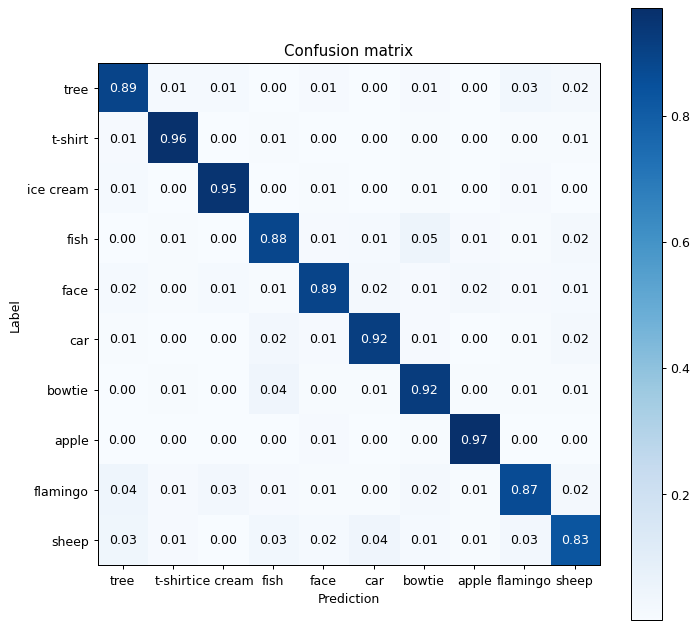

In [115]:
plt.rcParams['figure.figsize'] = [9, 9]
plt.rcParams['figure.dpi'] = 90 
plot_confusion_matrix_mnist(classifier, test_data_loader)